In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\..\.vscode\posco_analysis'))
	print(os.getcwd())
except:
	pass


In [37]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns 
import statsmodels.api as sm
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import os
import graphviz
import matplotlib.font_manager as font_manager


In [38]:
plt.rcParams['font.family'] = 'NanumBarunGothic'


In [39]:
ds_hmeq=pd.read_csv("data/HMEQ.csv",engine='python')


In [40]:
ds_hmeq.head()


BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1700    30548   40320.0  HomeImp   Other   9.0      0     0.0   
1    1  1800    28502   43034.0  HomeImp   Other  11.0      0     0.0   
2    0  2300   102370  120953.0  HomeImp  Office   2.0      0     0.0   
3    1  2400    34863   47471.0  HomeImp     Mgr  12.0      0     0.0   
4    0  2400    98449  117195.0  HomeImp  Office   4.0      0     0.0   

        CLAGE  NINQ  CLNO    DEBTINC  
0  101.466002   1.0     8  37.113614  
1   88.766030   0.0     8  36.884894  
2   90.992533   0.0    13  31.588503  
3   70.491080   1.0    21  38.263601  
4   93.811775   0.0    13  29.681827

In [41]:
ds_hmeq.isnull().sum(axis = 0)


BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [42]:
ds_hmeq["JOB"].fillna("Other",inplace = True)
ds_hmeq.fillna(ds_hmeq.mean(), inplace = True)


In [43]:
ds_hmeq_dummy = pd.get_dummies(ds_hmeq)
ds_hmeq_dummy.head()


BAD  LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
0    1  1700    30548   40320.0   9.0      0     0.0  101.466002   1.0     8   
1    1  1800    28502   43034.0  11.0      0     0.0   88.766030   0.0     8   
2    0  2300   102370  120953.0   2.0      0     0.0   90.992533   0.0    13   
3    1  2400    34863   47471.0  12.0      0     0.0   70.491080   1.0    21   
4    0  2400    98449  117195.0   4.0      0     0.0   93.811775   0.0    13   

     DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  JOB_Other  \
0  37.113614               0               1        0           0          1   
1  36.884894               0               1        0           0          1   
2  31.588503               0               1        0           1          0   
3  38.263601               0               1        1           0          0   
4  29.681827               0               1        0           1          0   

   JOB_ProfExe  JOB_Sales  JOB_Self  
0            0          0         0  
1            0          0         0  
2            0          0         0  
3            0          0         0  
4            0          0         0

In [44]:
np.random.seed(1234)
msk = np.random.rand(ds_hmeq_dummy.shape[0]) < 0.7
ds_hmeq_train = ds_hmeq_dummy[msk]
ds_hmeq_test = ds_hmeq_dummy[~msk]

ds_hmeq_train_y= ds_hmeq_train["BAD"]
ds_hmeq_train_x = ds_hmeq_train.drop("BAD",axis = 1, inplace = False)
ds_hmeq_test_y = ds_hmeq_test["BAD"]
ds_hmeq_test_x = ds_hmeq_test.drop("BAD",axis = 1, inplace = False)

print("train data X size : {}".format(ds_hmeq_train_x.shape))
print("train data Y size : {}".format(ds_hmeq_train_x.shape))
print("test data X size : {}".format(ds_hmeq_test_x.shape))
print("test data Y size : {}".format(ds_hmeq_test_y.shape))


train data X size : (2604, 18)
train data Y size : (2604, 18)
test data X size : (1144, 18)
test data Y size : (1144,)


In [45]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(ds_hmeq_train_x,ds_hmeq_train_y)
print("Accurary on training set:{:.3f}".format(tree_uncustomized.score(ds_hmeq_train_x,ds_hmeq_train_y)))
print("Accurary on test set:{:.3f}".format(tree_uncustomized.score(ds_hmeq_test_x,ds_hmeq_test_y)))



Accurary on training set:1.000
Accurary on test set:0.927


In [46]:
train_accuracy = []
test_accuracy = []

para_criterion = ["gini","entropy"]

for criterion in para_criterion:
    tree1 = DecisionTreeClassifier(criterion= criterion, random_state= 1234)
    tree1.fit(ds_hmeq_train_x,ds_hmeq_train_y)
    train_accuracy.append(tree1.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(tree1.score(ds_hmeq_test_x,ds_hmeq_test_y))

ds_accuracy1 = pd.DataFrame()
ds_accuracy1["Criterion"] = para_criterion
ds_accuracy1["TrainAccuracy"] = train_accuracy
ds_accuracy1["TestAccuracy"] = test_accuracy
ds_accuracy1.round(3)


Criterion  TrainAccuracy  TestAccuracy
0      gini            1.0         0.927
1   entropy            1.0         0.921

In [47]:
# 깊이 변경
train_accuracy = []; test_accuracy=[]
para_criterion = []; para_max_depth = []

n_iter_depth = 10

list_criterion = ['gini','entropy']

for criterion in list_criterion:
    for depth in range(1,n_iter_depth+1):
        tree2 = DecisionTreeClassifier(criterion=criterion, max_depth=depth,random_state=1234)
        tree2.fit(ds_hmeq_train_x,ds_hmeq_train_y)

        train_accuracy.append(tree2.score(ds_hmeq_train_x,ds_hmeq_train_y))
        test_accuracy.append(tree2.score(ds_hmeq_test_x,ds_hmeq_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(depth)
        


In [48]:
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["Depth"] = para_max_depth
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2.round(3)



Criterion  Depth  TrainAccuracy  TestAccuracy
0       gini      1          0.924         0.927
1       gini      2          0.930         0.932
2       gini      3          0.931         0.932
3       gini      4          0.934         0.934
4       gini      5          0.937         0.934
5       gini      6          0.938         0.937
6       gini      7          0.944         0.934
7       gini      8          0.952         0.935
8       gini      9          0.959         0.936
9       gini     10          0.965         0.943
10   entropy      1          0.924         0.927
11   entropy      2          0.930         0.932
12   entropy      3          0.930         0.932
13   entropy      4          0.934         0.933
14   entropy      5          0.937         0.933
15   entropy      6          0.938         0.934
16   entropy      7          0.941         0.932
17   entropy      8          0.951         0.934
18   entropy      9          0.957         0.934
19   entropy     10          0.965         0.938

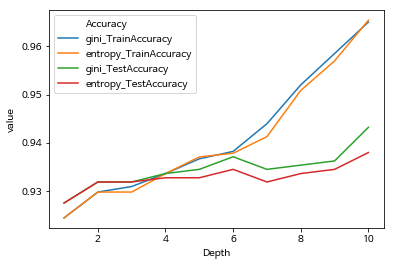

In [49]:
# 자기자신에만 영향을 받는 과적합상태
ds_accuracy2_melt = pd.melt(ds_accuracy2,id_vars=["Criterion","Depth"])
ds_accuracy2_melt["Accuracy"]=ds_accuracy2_melt["Criterion"]+ "_" + ds_accuracy2_melt["variable"]
sns.lineplot(x="Depth",y="value",hue = "Accuracy", data = ds_accuracy2_melt)



In [50]:
train_accuracy = []; test_accuracy = []

para_criterion = []; para_max_depth=[];para_min_leaf_size = []
# 최대깊이 10
max_depth= 10

list_min_leaf_size = [i*10 for i in range(1,6)]

for criterion in list_criterion:
    for leafsize in list_min_leaf_size:
        tree3 = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,min_samples_leaf=leafsize,random_state=1234)

        tree3.fit(ds_hmeq_train_x,ds_hmeq_train_y)
        train_accuracy.append(tree3.score(ds_hmeq_train_x,ds_hmeq_train_y))
        test_accuracy.append(tree3.score(ds_hmeq_test_x,ds_hmeq_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(max_depth)
        para_min_leaf_size.append(leafsize)



In [51]:
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"]= para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["MinLeafSize"] = para_min_leaf_size
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3["TestAccuracy"] = test_accuracy
ds_accuracy3.round(3)


Criterion  Depth  MinLeafSize  TrainAccuracy  TestAccuracy
0      gini     10           10          0.945         0.935
1      gini     10           20          0.931         0.924
2      gini     10           30          0.929         0.929
3      gini     10           40          0.926         0.924
4      gini     10           50          0.924         0.930
5   entropy     10           10          0.944         0.930
6   entropy     10           20          0.930         0.925
7   entropy     10           30          0.927         0.933
8   entropy     10           40          0.924         0.927
9   entropy     10           50          0.924         0.930

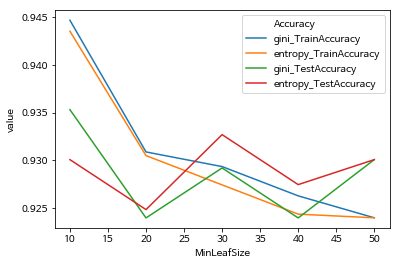

In [52]:
ds_accuracy3_melt = pd.melt(ds_accuracy3, id_vars=["Criterion","Depth","MinLeafSize"])
ds_accuracy3_melt["Accuracy"] = ds_accuracy3_melt["Criterion"] + "_" + ds_accuracy3_melt["variable"]
sns.lineplot(x="MinLeafSize",y="value",hue = "Accuracy", data= ds_accuracy3_melt)


In [53]:
tree = DecisionTreeClassifier(criterion="gini",max_depth=4,random_state=1234)

tree.fit(ds_hmeq_train_x,ds_hmeq_train_y)

export_graphviz(tree,out_file="tree.dot",class_names=["0","1"],feature_names=ds_hmeq_train_x.columns,impurity = False, filled = True)

# graphviz2.38 다운받는 경로
os.environ["PATH"] += os.pathsep + "C:\Program Files (x86)\Graphviz2.38\bin"

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [54]:
tree4 = DecisionTreeClassifier(criterion= "gini",max_depth=4,min_samples_leaf=50,random_state=1234)
tree5 = tree4.fit(ds_hmeq_train_x,ds_hmeq_train_y)
export_graphviz(tree5,out_file = "tree2.dot",class_names=["0","1"],
feature_names= ds_hmeq_train_x.columns,impurity = False, filled = True)

with open("tree2.dot")as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))



ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [55]:
tree4 = DecisionTreeClassifier(criterion="gini",max_depth=4,min_samples_leaf= 200,random_state=1234)
tree5 = tree4.fit(ds_hmeq_train_x,ds_hmeq_train_y)

export_graphviz(tree5,out_file="tree3.dot",class_names=["0","1"],
feature_names=ds_hmeq_train_x.columns,impurity = False, filled=True)

with open("tree3.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

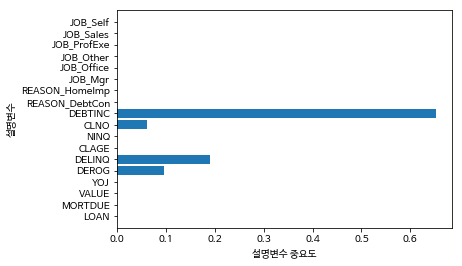

In [56]:
# 결론도출
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = ds_hmeq_train_x.columns
ds_feature_importance["Importance"] = tree.feature_importances_

ds_feature_importance.sort_values("Importance",ascending = False)
ds_feature_importance.round(3)

def plot_feature_importances(model):
    n_features = ds_hmeq_train_x.shape[1]
    plt.barh(range(n_features),model.feature_importances_,align = "center")
    plt.yticks(np.arange(n_features),ds_hmeq_train_x.columns)
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1,n_features)

plot_feature_importances(tree)
